In [4]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import suite2p
from scanimagetiffio import SITiffIO
#import utils_image from the parent folder
import sys
sys.path.append("..")
from utils_image import UnrotateCropFrame, RegFrame, compute_zpos_sp


In [5]:
# read the rotation center from the circlecenter txt file
circlecenterfilename = "/home/zilong/Desktop/2D2P/Data/183_25072023/DP/circlecenter.txt"
with open(circlecenterfilename, "r") as f:
    # read the last row
    last_line = f.readlines()[-1]
    # assign the x and y coordinates to self.rotx and self.roty
    rotx = float(last_line.split()[0])
    roty = float(last_line.split()[1])

In [ ]:
#load the zstack tiff and calculate the mean frames for each stack

zstacktiff = '/home/zilong/Desktop/2D2P/Data/183_25072023/stack_00002.tif'
ztstackrelog = '/home/zilong/Desktop/2D2P/Data/183_25072023/REdata_20230725_160414.stack.txt'

S = SITiffIO()
S.open_tiff_file(zstacktiff, "r")
S.open_rotary_file(ztstackrelog)
S.interp_times()  # might take a while...

#get all frames and angles in S
Array = []; 
for i in range(S.get_n_frames()):
    Array.append(S.get_frame(i+1))
#change Array to a numpy array
Array = np.array(Array)
Angle = S.get_all_theta()

# unrotate each frame in the tiff file with the detected rotation center
unrotcropFrames = UnrotateCropFrame(Array, Angle, rotCenter=[rotx,roty])


num_v=5; num_s=41; num_f=10
# reshape the unrotFrames to a 5D array
unrotcropFrames = unrotcropFrames.reshape(
    num_v, num_s, num_f, unrotcropFrames.shape[1], unrotcropFrames.shape[2]
)
# average across the first and third dimension
meanZstacks = np.mean(unrotcropFrames, axis=(0, 2))
             

Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/162/REdata_20230619_165713.txt
Finished calculating rotations and times.
The rotary encoder file has 22266 timestamps in it.
Counted 2050 frames


: 

: 

In [10]:
#load the imaging tiff 
imagingtiff = '/home/zilong/Desktop/2D2P/Data/162/162_block1_19062023__00001.tif'
imagingrelog = '/home/zilong/Desktop/2D2P/Data/162/REdata_20230619_170256.txt'

S = SITiffIO()
S.open_tiff_file(imagingtiff, "r")
S.open_rotary_file(imagingrelog)
#extract the last self.numFrames frames from the tiff file
tailArray, tailAng = S.tail(500)
        
# unrotate each frame in the tiff file with the detected rotation center
unrotFrames  = UnrotateCropFrame(tailArray, tailAng, rotCenter=[rotx,roty])

#perform image registraion
meanRegImg, regFrames = RegFrame(unrotFrames)

Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/162/REdata_20230619_170256.txt
Calculating rotations and times from rotary encoder data...
Finished calculating rotations and times.
The rotary encoder file has 79743 timestamps in it.
Counted 18000 frames
Reference frame, 3.57 sec.
Registered 200/500 in 1.62s
Registered 400/500 in 3.29s
Registered 500/500 in 3.98s


In [11]:
#comnpute the z drift of each frame
ops = suite2p.default_ops()
zcorr = compute_zpos_sp(meanZstacks, regFrames, ops)

1 planes, 0/500 frames, 0.26 sec.
11 planes, 0/500 frames, 1.21 sec.
21 planes, 0/500 frames, 2.07 sec.
31 planes, 0/500 frames, 2.95 sec.
40 planes, 0/500 frames, 3.77 sec.
1 planes, 100/500 frames, 3.95 sec.
11 planes, 100/500 frames, 4.87 sec.
21 planes, 100/500 frames, 5.74 sec.
31 planes, 100/500 frames, 6.71 sec.
40 planes, 100/500 frames, 7.47 sec.
1 planes, 200/500 frames, 7.63 sec.
11 planes, 200/500 frames, 8.53 sec.
21 planes, 200/500 frames, 9.62 sec.
31 planes, 200/500 frames, 11.82 sec.
40 planes, 200/500 frames, 14.21 sec.
1 planes, 300/500 frames, 14.73 sec.
11 planes, 300/500 frames, 16.55 sec.
21 planes, 300/500 frames, 17.59 sec.
31 planes, 300/500 frames, 18.90 sec.
40 planes, 300/500 frames, 20.89 sec.
1 planes, 400/500 frames, 21.61 sec.
11 planes, 400/500 frames, 24.39 sec.
21 planes, 400/500 frames, 25.21 sec.
31 planes, 400/500 frames, 26.10 sec.
40 planes, 400/500 frames, 26.84 sec.


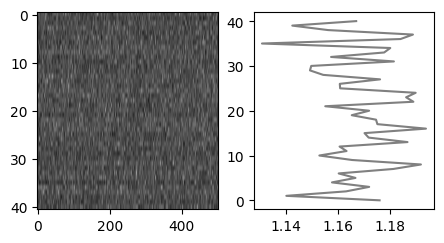

In [14]:
#imshow zcorr with auto aspect ratio
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(512/100,256/100),dpi=100)
#subplot 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(zcorr, cmap='gray', aspect='auto')
ax2 = fig.add_subplot(1, 2, 2)
nplanes = zcorr.shape[0]
sumCorrMatrix = np.sum(zcorr, axis=1)
ax2.plot(sumCorrMatrix, np.arange(0, nplanes), color='grey')
plt.show()

In [ ]:
#add gaussan smoothing to the corrMatrix
zcorr_smooth = gaussian_filter1d(zcorr.copy(), 2, axis=0)

#imshow zcorr with auto aspect ratio
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(512/100,256/100),dpi=100)
#subplot 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(zcorr_smooth, cmap='gray', aspect='auto')
ax2 = fig.add_subplot(1, 2, 2)
nplanes = zcorr_smooth.shape[0]
sumCorrMatrix = np.sum(zcorr, axis=1)
ax2.plot(sumCorrMatrix, np.arange(0, nplanes), color='grey')
plt.show()